In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.base import clone


with open('../../data/DatasetCleaned.csv', 'r') as f:
    DATA = pd.read_csv(f)


Y_DATA = np.log(DATA['SalePrice'].copy()).values
VAR_DEPENDENT = 'SalePrice_log'

X_DATA = DATA.copy().drop(columns=['SalePrice','Unnamed: 0'])


def PrepX(X:pd.DataFrame, scaler_type=PowerTransformer(method='yeo-johnson'), 
          only_dummies:bool=False, fit:bool=False):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Stores Scalers later in Dictionary (Column:Scaler)
    if fit: scalers = {}
    else: scalers = scaler_type

    new_cols = []

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    for col, t in X_types.items():

        #Dummy columns and Percentages that don't need to be scaled (computed in Preperation.ipynb)
        if t != 'object' and -1 <= X[col].min() and X[col].max() <= 1 and not only_dummies: 
            new_cols.append(X[col].copy().replace({-1:0})) 
            continue

        #Transforms Numeric values; either builds scalers or applies them
        if t in ['int', 'float'] and not only_dummies:
            nonapplicable = X[col] == -1

            new_col = X[col].copy()
            applic_values = new_col.loc[~nonapplicable].values.reshape(-1, 1)

            #If fit=True, construct a new scaler for the training data. Otherwise, use the SCALER dict to scale test data
            if fit: 
                scaler = clone(scaler_type)
                scaler.fit(applic_values)
                scalers[col] = scaler
                new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
            else:
                new_col.loc[~nonapplicable] = scalers[col].transform(applic_values).flatten()


            new_col.loc[nonapplicable] = 0

            new_cols.append(new_col)
            
            continue

        #Create dummies for categorical (str) columns; with Validation set this is done before splitting
        if t == 'object': 
            new_col = pd.get_dummies(X[col].copy(), prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        #This is only relevant when creating only dummies for the validation Set to not loose columns
        if only_dummies and t != 'object':
            X_prep[col] = X[col].copy()
        else:
            print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    if fit: return X_prep, scalers
    else: return X_prep

#Split data into train and validation set. 
# #train_test_split is not because before splitting we need to ensure that all dummy variables are present to not have missing columns in either set
def Split(X:pd.DataFrame, Y:pd.DataFrame, TestSize:float, random_state:int=42):

    X = PrepX(X_DATA, only_dummies=True, fit=False)

    split_index = np.random.RandomState(random_state) \
                           .choice([True, False], size=len(Y), p=[TestSize,1-TestSize])
    
    X_test = X[split_index]
    X_train = X[~split_index]
    Y_test = Y[split_index]
    Y_train = Y[~split_index]

    return X_test, X_train, Y_test, Y_train


VALIDATION_SET = True
if VALIDATION_SET: 
    X_VAL, X_DATA, Y_VAL, Y_DATA = Split(X_DATA, Y_DATA, 0.05, 1)

X_DATA, SCALER = PrepX(X=X_DATA, fit=True)
VAR_NAMES = X_DATA.columns
X_DATA = X_DATA.values.reshape(-1,X_DATA.shape[1])

if VALIDATION_SET:
    X_VAL = PrepX(X=X_VAL, scaler_type=SCALER)
    X_VAL = X_VAL.values.reshape(-1, X_VAL.shape[1])

C:\Users\karli\AppData\Local\Temp\ipykernel_61808\2351897555.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.14237796  0.10378787  0.09366802 ... -1.69316454  4.04584219
 -0.37038692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_61808\2351897555.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.66439574 -0.04777608  0.66439574 ... -0.04777608  2.66102288
 -0.79040246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
C:\Users\karli\AppData\Local\Temp\ipykernel_61808\2351897555.py:49: FutureWarning: Setting an item of incompatible dtype is 

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, cross_val_score

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

def RegrLasso(Y, X, dependent_var:str, feature_names:list, alpha, #Function imported from another project of mine, see https://github.com/Interorm/IMF-Bias---Hausarbeit
              display:bool=True, iter:int=1000000):

    #Creates Lasso models for all alpha values to compare MSE 
    if display:
        coefs_all = [] 
        mse = []
        for a in tqdm(alpha): 
            lasso = Lasso(alpha=a,  max_iter=iter, tol=1e-4, random_state=42)
            lasso.fit(X, Y) 
            coefs_all.append(lasso.coef_) 
            mse_this = np.mean( -cross_val_score(lasso, X, Y, scoring="neg_mean_squared_error", cv=KFold(), n_jobs=-1) )
            mse.append(mse_this)
        coefs_all = np.array(coefs_all)
    

    #Create best Lasso model, minimising Prediction MSE measured by KFold
    lasso_cv = LassoCV(alphas=alpha, cv=KFold(), max_iter=iter, random_state=42)
    lasso_cv.fit(X, Y)

    #Display Model Stats
    best_alpha = lasso_cv.alpha_
    print("Best alpha:", best_alpha)

    best_r2 = np.mean(cross_val_score(lasso_cv, X, Y, scoring="r2", cv=KFold(), n_jobs=-1))
    print(f"Test R²: {best_r2}")
    best_mse = np.mean(-cross_val_score(lasso_cv, X, Y, scoring="neg_mean_squared_error", cv=KFold(), n_jobs=-1))
    print(f'Test MSE: {best_mse}')

    coefs = []
    for i, featuer in enumerate(feature_names):
        coef = lasso_cv.coef_[i]
        if coef == 0: continue
        coefs.append({"Regressor": featuer, "Coefficient": coef})
    coefs = sorted(coefs, key = lambda x: x["Coefficient"], reverse=True)
    for coef in coefs: 
        c = round(coef["Coefficient"], 4)
        r = coef["Regressor"]
        print(f"{r}: {c}")

    #Display Regularization Path
    if display: 
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
        
        # Top Left axis: MSE
        ax1.plot(alpha, mse, color="red", linewidth=2, label="CV MSE")
        ax1.set_xlabel("Lambda")
        ax1.set_xscale("log")
        ax1.set_ylabel("Mean Squared Error")
        ax1.set_title('Mean Squared Error')
        ax1.axvline(x = best_alpha, color = 'black', linestyle = '--')
        #ax1.tick_params(axis="y", labelcolor="red")

        # Top Right axis: Coefficients
        colors = sns.color_palette("Paired", len(feature_names))
        for i, name in enumerate(feature_names):
            ax2.plot(alpha, coefs_all[:, i], label=name, color=colors[i])
        ax2.set_xlabel("Lambda")
        ax2.set_xscale("log")
        ax2.set_ylabel("Coefficient values")
        ax2.set_title("Lasso Coefficients vs Lambda")
        ax2.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax2.grid(True)

        # Bottom Left: Predcition vs. Truth
        Y_predicted = pd.DataFrame({'Predicted':lasso_cv.predict(X), 'True':Y})
        Y_predicted = Y_predicted.sort_values(by='True')
        ax3.plot( Y_predicted['True'], Y_predicted['Predicted'], color='lightblue', label='Predicted Values' )
        ax3.plot( Y_predicted['True'], Y_predicted['True'], color = 'red' )
        ax3.set_xlabel(f'Actual {dependent_var}')
        ax3.set_ylabel(f'Predicted {dependent_var}')
        ax3.set_title('Prediction vs. Reality for Best Model')
        ax3.grid(False)

        # Bottom Right: Number of relevant Coef
        ax4.plot(alpha, np.count_nonzero(coefs_all, axis=1), color='red', label = 'Non-Zero Coefficients')
        ax4.set_xlabel("Lambda")
        ax4.set_xscale("log")
        ax4.set_ylabel("# Non-Zero Coefficients")
        ax4.set_title("Non-Zero Coefficients")
        ax4.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax4.grid(True)


        plt.tight_layout()
        plt.show()

    return lasso_cv


  0%|          | 0/500 [00:00<?, ?it/s]

Best alpha: 0.0007740652213677225
Test R²: 0.8912818589399769
Test MSE: 0.017106357272346315
Has_Basement: 0.1444
GrLivArea: 0.1258
Neighborhood_StoneBr: 0.1063
Neighborhood_Crawfor: 0.0927
Neighborhood_Somerst: 0.0878
OverallQual: 0.0793
Neighborhood_NridgHt: 0.0698
Neighborhood_NoRidge: 0.0657
Has_Garage: 0.064
SaleType_New: 0.0579
Condition1_Norm: 0.0577
MSZoning_RL: 0.0536
OverallCond: 0.0495
SaleCondition_Normal: 0.0492
Exterior1st_BrkFace: 0.0479
Neighborhood_BrkSide: 0.044
LotArea: 0.0371
CentralAir: 0.0339
GarageCars: 0.0296
Has_Fireplace: 0.0275
BsmtFinish_GLQ: 0.0235
2ndFlrSF: 0.0219
GarageType_Detchd: 0.0218
TotalBsmtSF: 0.0202
MSSubClass_1-STORY 1946 & NEWER ALL STYLES: 0.0188
BsmtBathrooms: 0.0186
Bathrooms: 0.0179
1stFlrSF: 0.0174
LandSlope_Mod: 0.0153
Sold_07-2007: 0.0133
HeatingQC: 0.0122
BsmtQual: 0.012
Sold_12-2007: 0.012
GarageFinish: 0.0113
WoodDeckSF: 0.0113
GarageType_Attchd: 0.0106
BsmtExposure: 0.0103
GarageQual: 0.0094
FireplaceQu: 0.0084
Neighborhood_ClearCr: 

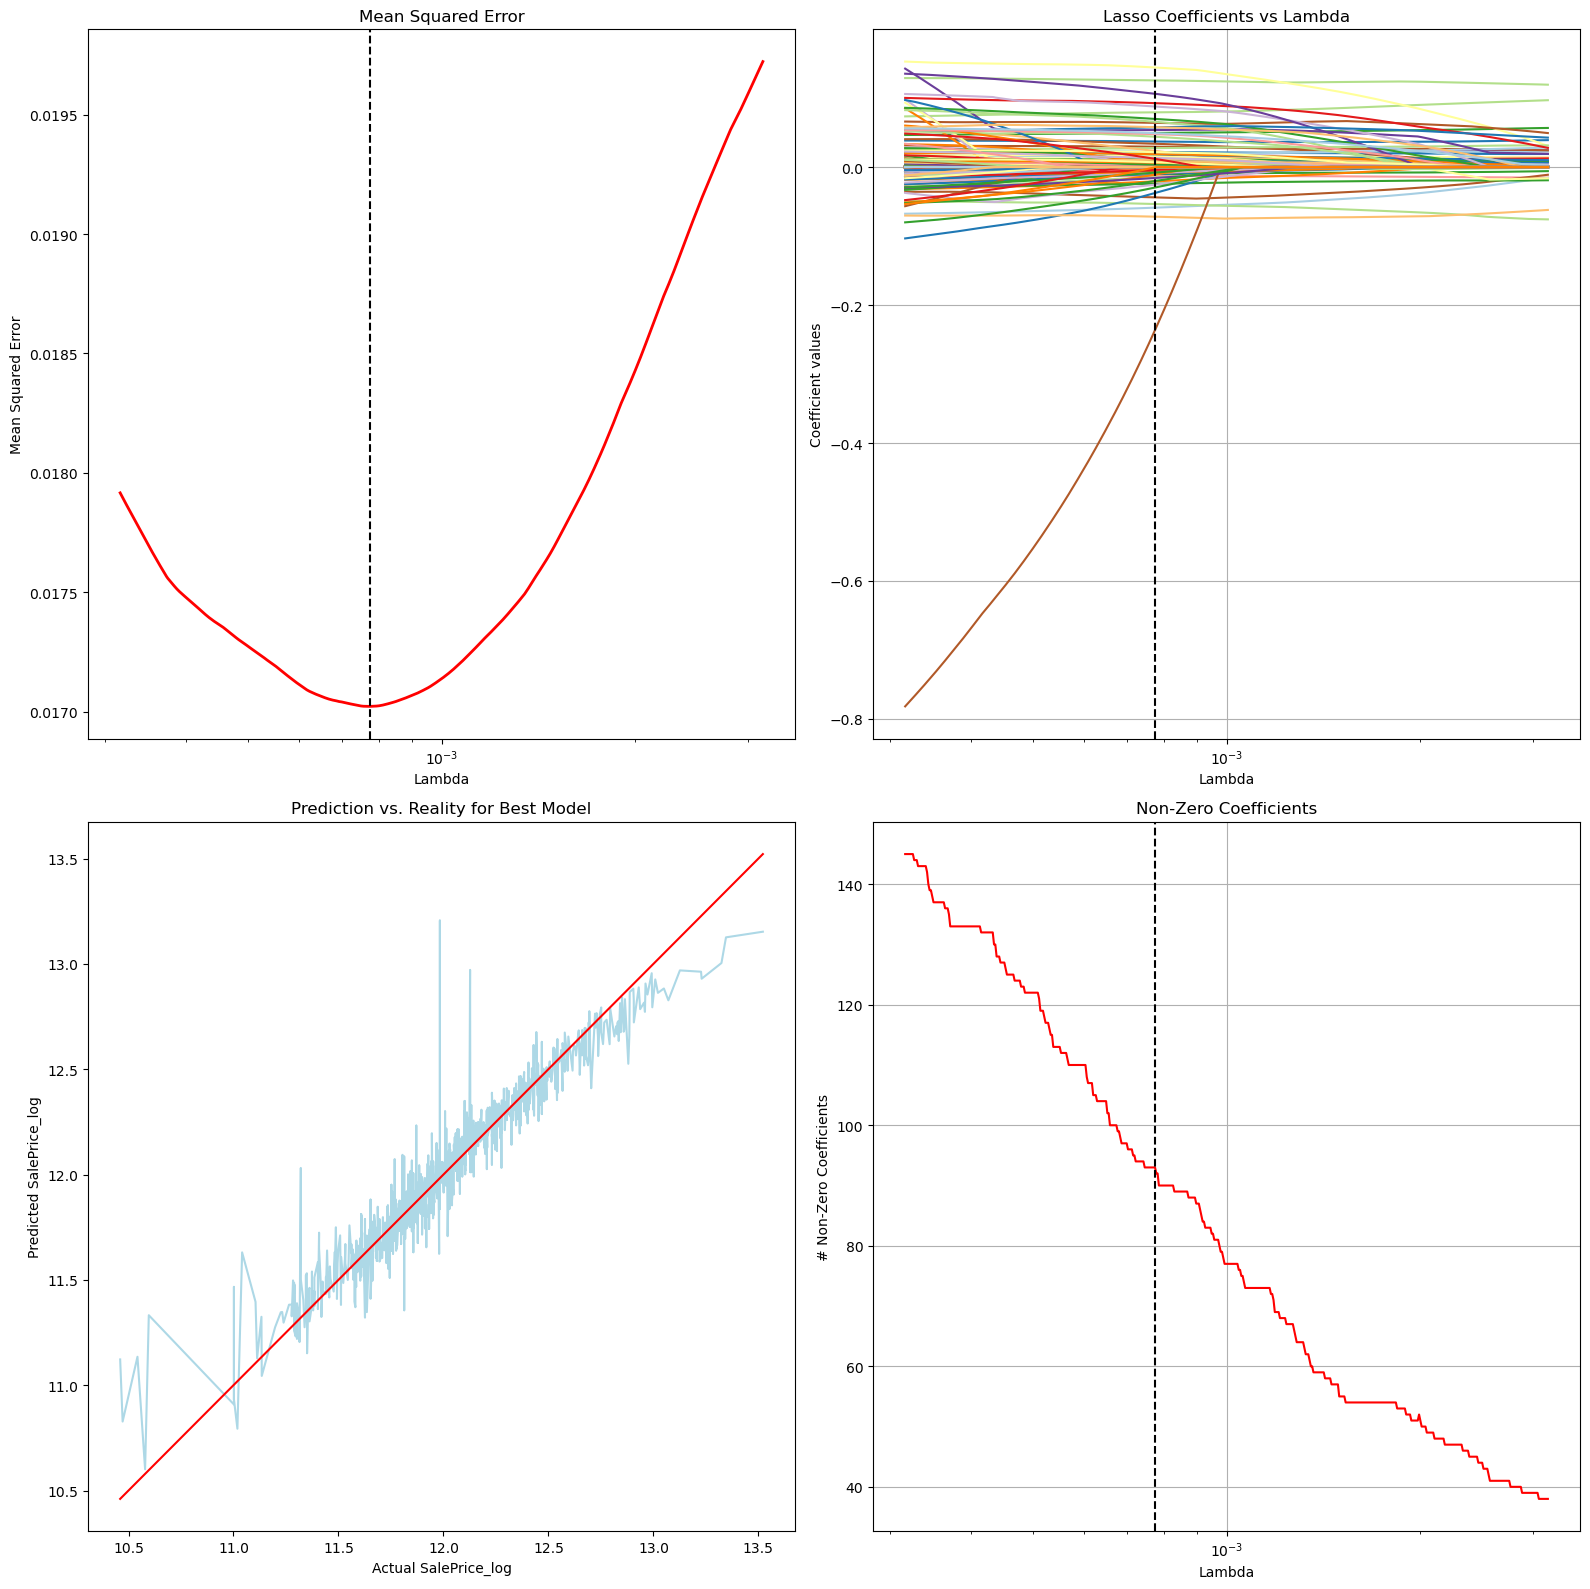

In [ ]:
lasso_model = RegrLasso(Y_DATA, X_DATA, VAR_DEPENDENT, VAR_NAMES,  alpha=np.logspace(-4,-2.5,500))

In [56]:
from sklearn.metrics import root_mean_squared_error
import pickle

print(f'Deviation from actual Price: {root_mean_squared_error(np.exp(Y_VAL), np.exp(lasso_model.predict(X_VAL)))}')

with open('models/Lasso.sav', 'wb') as f: pickle.dump({'Model':lasso_model,'Scaler':SCALER}, f)

Deviation from actual Price: 17743.10574027774


In [57]:
import pickle

with open('models/Lasso.sav', 'wb') as f: pickle.dump({'Model':lasso_model,'Scaler':SCALER}, f)